In [57]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scipy.stats as ss
from scipy.optimize import curve_fit
from ntuple_lib import *
beautify_plots(plt)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib as mpl

In [2]:
def t_stats_tracks_in_vtxs(vertex_tracks_idx, track_t, v_zs):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event, event_zs) in enumerate(zip(vertex_tracks_idx, v_zs)):
        event_all_t = []
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        for vertex_tracks, z in zip(event, event_zs):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                event_all_t.append(ts)
                avg_t = np.mean(ts[np.logical_and(ts != -1e3, ts != -1e6)])
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        all_ts.append(np.array(event_all_t))
        avg_ts.append(np.array(event_avg_t))
        rms_ts.append(np.array(event_rms_t))
        stat_zs.append(np.array(event_stat_zs))
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

def t_stats_tracks_in_jets(vertex_tracks_idx, track_t):
    avg_ts = []
    rms_ts = []
    
    for i, event in enumerate(vertex_tracks_idx):
        event_avg_t = []
        event_rms_t = []
        for vertex_tracks in event:
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks])
                avg_t = np.mean(ts[np.logical_and(ts != -1e3, ts != -1e6)])
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
    return np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object')
    
def t_stats_tracks_in_vtxs_pTcut(track_t, vertex_tracks_idx, vertex_zs, vertex_sumPt2, sumPt2_min):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event_vertex_track_idx, event_vertex_zs, event_vertex_sumPt2) in enumerate(zip(vertex_tracks_idx, vertex_zs, vertex_sumPt2)):
        event_all_ts =  []
        event_avg_t =   []
        event_rms_t =   []
        event_stat_zs = []
        
        hard_enough_vertex_idx = event_vertex_sumPt2 > sumPt2_min
        
        for vertex_tracks, z in zip(event_vertex_track_idx[hard_enough_vertex_idx], event_vertex_zs[hard_enough_vertex_idx]):
            if len(vertex_tracks) > 0:
                ts = np.array(track_t[i][vertex_tracks], dtype='object')
                event_all_ts.append(ts)
                
                ##Ugly hack
                event_all_ts.append(np.array([])) 
                
                avg_t = np.mean(ts[np.logical_and(ts != -1e3, ts != -1e6)])
                rms_t = np.sqrt(np.mean(ts**2))
                event_avg_t.append(avg_t)
                event_rms_t.append(rms_t)
                event_stat_zs.append(z)
        avg_ts.append (np.array(event_avg_t))
        rms_ts.append (np.array(event_rms_t))
        stat_zs.append(np.array(event_stat_zs))
        all_ts.append (np.array(event_all_ts, dtype='object'))
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

In [3]:
files = ['ntuples_condor/OutDir_{}/hist-Rel21sample.root'.format(i) for i in range(1, 10)]
track_t = np.array([], dtype='object')
track_t30 = np.array([], dtype='object')
track_t90 = np.array([], dtype='object')
track_t180 = np.array([], dtype='object')

reco_vertex_track_idxs = np.array([], dtype='object')
truth_vertex_track_idxs = np.array([], dtype='object')
jet_track_idxs = np.array([], dtype='object')

reco_vertex_sumPt2 = np.array([], dtype='object')

reco_vertex_z = np.array([], dtype='object')
truth_vertex_z = np.array([], dtype='object')

for file in files:
    root_file = uproot.open(file)
    for key in root_file.keys():
        if key.startswith('EventTree'):
            tree = root_file[key]
            track_t = np.concatenate((track_t, tree['track_t'].array(library='np')))
            track_t30 = np.concatenate((track_t30, tree['track_t30'].array(library='np')))
            track_t90 = np.concatenate((track_t90, tree['track_t90'].array(library='np')))
            track_t180 = np.concatenate((track_t180, tree['track_t180'].array(library='np')))
            
            reco_vertex_track_idxs = np.concatenate((reco_vertex_track_idxs, tree['recovertex_tracks_idx'].array(library='np')))
            truth_vertex_track_idxs = np.concatenate((truth_vertex_track_idxs, tree['truthvertex_tracks_idx'].array(library='np')))
            jet_track_idxs = np.concatenate((jet_track_idxs, tree['jet_tracks_idx'].array(library='np')))
            
            reco_vertex_sumPt2 = np.concatenate((reco_vertex_sumPt2, tree['recovertex_sumPt2'].array(library='np')))
            
            reco_vertex_z = np.concatenate((reco_vertex_z, tree['recovertex_z'].array(library='np')))
            truth_vertex_z = np.concatenate((truth_vertex_z, tree['truthvertex_z'].array(library='np')))

In [ ]:
track_t_flat = flatten_array(track_t)
track_t30_flat = flatten_array(track_t30)
track_t90_flat = flatten_array(track_t90)
track_t180_flat = flatten_array(track_t180)

In [4]:
rev_all_ts, rev_avg_ts, rev_rms_ts, rev_stat_z = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t, reco_vertex_z)
rev_all_ts30, rev_avg_ts30, rev_rms_ts30, rev_stat_z30 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t30, reco_vertex_z)
rev_all_ts90, rev_avg_ts90, rev_rms_ts90, rev_stat_z90 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t90, reco_vertex_z)
rev_all_ts180, rev_avg_ts180, rev_rms_ts180, rev_stat_z180 = t_stats_tracks_in_vtxs(reco_vertex_track_idxs, track_t180, reco_vertex_z)

trv_all_ts, trv_avg_ts, trv_rms_ts, trv_stat_z = t_stats_tracks_in_vtxs(truth_vertex_track_idxs, track_t, truth_vertex_z)

jet_avg_ts, jet_rms_ts = t_stats_tracks_in_jets(jet_track_idxs, track_t)

trv_all_ts_flat = flatten_array(trv_all_ts)
rev_all_ts_flat = flatten_array(rev_all_ts)
rev_all_ts30_flat = flatten_array(rev_all_ts30)
rev_all_ts90_flat = flatten_array(rev_all_ts90)
rev_all_ts180_flat = flatten_array(rev_all_ts180)

trv_all_ts_flat2 = flatten_array(trv_all_ts_flat)
rev_all_ts_flat2 = flatten_array(rev_all_ts_flat)
rev_all_ts30_flat2 = flatten_array(rev_all_ts30_flat)
rev_all_ts90_flat2 = flatten_array(rev_all_ts90_flat)
rev_all_ts180_flat2 = flatten_array(rev_all_ts180_flat)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
trv_avg_ts_flat = flatten_array(trv_avg_ts)
jet_avg_ts_flat = flatten_array(jet_avg_ts)

rev_avg_ts30_flat = flatten_array(rev_avg_ts30)
rev_avg_ts90_flat = flatten_array(rev_avg_ts90)
rev_avg_ts180_flat = flatten_array(rev_avg_ts180)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
trv_rms_ts_flat = flatten_array(trv_rms_ts)
jet_rms_ts_flat = flatten_array(jet_rms_ts)

rev_stat_z_flat = flatten_array(rev_stat_z)
trv_stat_z_flat = flatten_array(trv_stat_z)

<ipython-input-2-4d81c7d0f8ba>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_ts.append(np.array(event_all_t))
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, 'z')

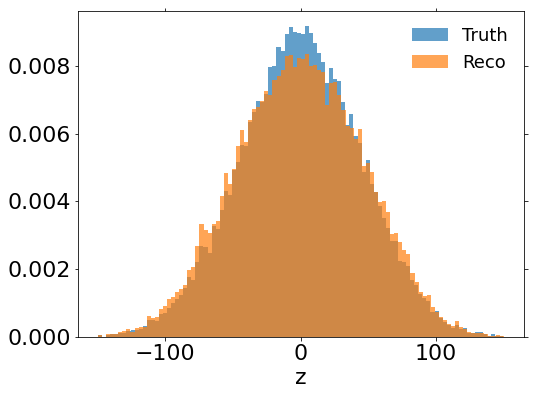

In [20]:
max_z = 150

rev_idx = np.abs(rev_stat_z_flat) < max_z
trv_idx = np.abs(trv_stat_z_flat) < max_z

_ = plt.hist(trv_stat_z_flat[trv_idx], bins=100, alpha=0.7, density=True, label='Truth')
_ = plt.hist(rev_stat_z_flat[rev_idx], bins=100, alpha=0.7, density=True, label='Reco')

plt.legend(frameon=False)
plt.xlabel('z')

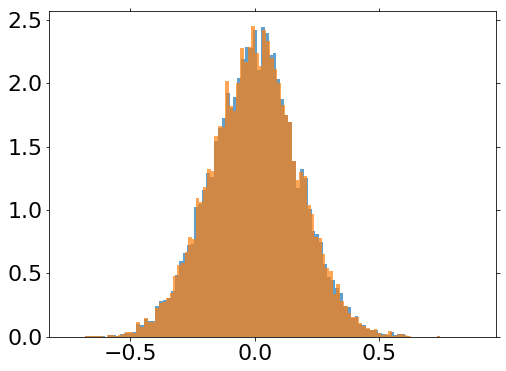

In [14]:
max_t = 1

rev_idx = np.abs(rev_all_ts_flat2) < max_z
trv_idx = np.abs(trv_all_ts_flat2) < max_z

_ = plt.hist(rev_all_ts_flat2[rev_idx], bins=100, alpha=0.7, density=True)
_ = plt.hist(trv_all_ts_flat2[trv_idx], bins=100, alpha=0.7, density=True)

Text(0.5, 0, 'Avg track t')

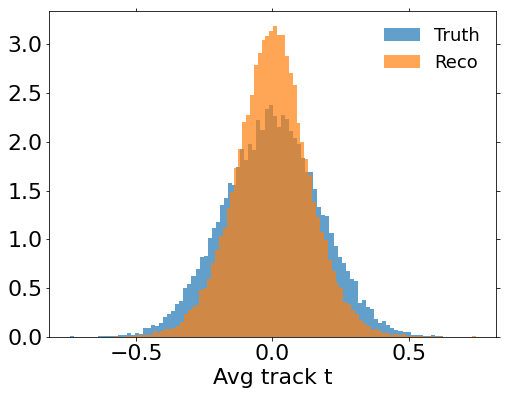

In [21]:
max_t = 1

rev_idx = np.abs(rev_avg_ts_flat) < max_t
trv_idx = np.abs(trv_avg_ts_flat) < max_t

_ = plt.hist(trv_avg_ts_flat[trv_idx], bins=100, alpha=0.7, density=True, label='Truth')
_ = plt.hist(rev_avg_ts_flat[rev_idx], bins=100, alpha=0.7, density=True, label='Reco')

plt.legend(frameon=False)
plt.xlabel('Avg track t')

Text(0, 0.5, 'Truth vertex avg track t (ns)')

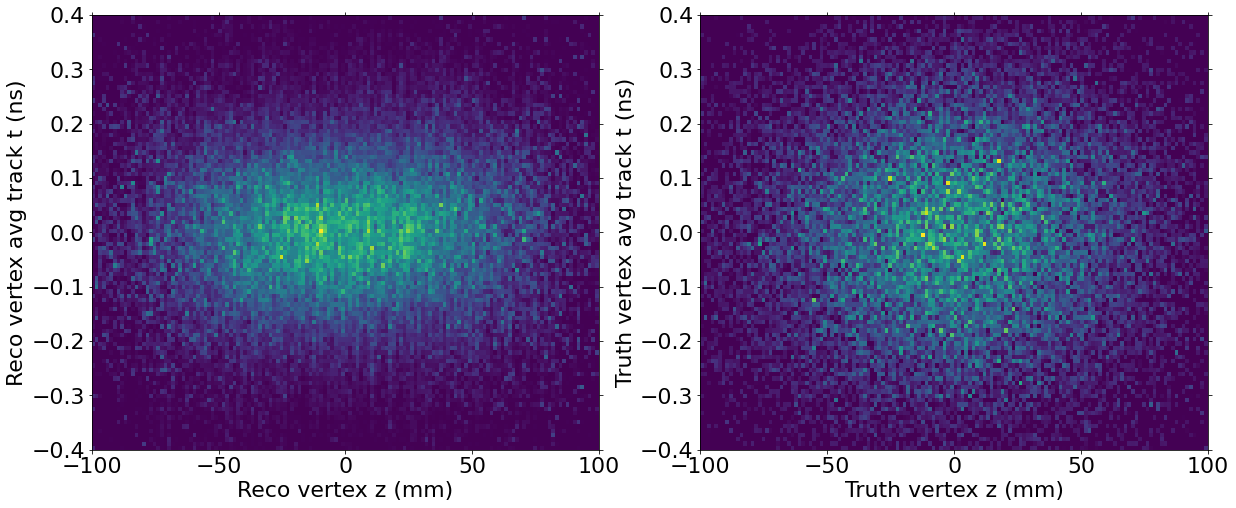

In [8]:
t_range = 0.4
z_range = 100
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 8)


re_avg_idxs = np.abs(rev_avg_ts_flat) < t_range
re_z_idxs = np.abs(rev_stat_z_flat) < z_range
re_idxs = np.logical_and(re_avg_idxs, re_z_idxs)

_ = ax1.hist2d(rev_stat_z_flat[re_idxs], rev_avg_ts_flat[re_idxs], bins=(140, 100))


tr_avg_idxs = np.abs(trv_avg_ts_flat) < t_range
tr_z_idxs = np.abs(trv_stat_z_flat) < z_range

tr_idxs = np.logical_and(tr_avg_idxs, tr_z_idxs)

_ = ax2.hist2d(trv_stat_z_flat[tr_idxs], trv_avg_ts_flat[tr_idxs], bins=(140, 100))


ax1.set_xlim(-z_range, z_range)
ax1.set_ylim(-t_range, t_range)
ax1.set_xlabel('Reco vertex z (mm)')
ax1.set_ylabel('Reco vertex avg track t (ns)')

ax2.set_xlim(-z_range, z_range)
ax2.set_ylim(-t_range, t_range)
ax2.set_xlabel('Truth vertex z (mm)')
ax2.set_ylabel('Truth vertex avg track t (ns)')

In [35]:
rev_all_ts_flat[0]

array([-0.1931045 , -0.14122012, -0.14122012, -0.1931045 , -0.1931045 ,
        0.03287256, -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.19005495, -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.19168945, -0.1931045 ,
       -0.1931045 ,  0.05150782, -0.1931045 , -0.1931045 , -0.1931045 ],
      dtype=float32)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(22, 8)

t_max = 0.5
labels = ['Truth', 'Reco no smearing', 'Reco 30 ps', 'Reco 90 ps', 'Reco 180 ps']
fmts = ['k-', 'k--', 'g', 'r', 'b']

for fmt, label, all_ts in zip(fmts, labels, (trv_all_ts_flat2, rev_all_ts_flat2, rev_all_ts30_flat2, rev_all_ts90_flat2, rev_all_ts180_flat2)):
    idxs = np.abs(all_ts) < t_max
    bin_heights, bin_borders, _ = ax1.hist(all_ts[idxs], bins=300, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax1.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=2, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)

for fmt, label, avg_ts in zip(fmts, labels, (trv_avg_ts_flat, rev_avg_ts_flat, rev_avg_ts30_flat, rev_avg_ts90_flat, rev_avg_ts180_flat)):
    idxs = np.abs(avg_ts) < t_max
    bin_heights, bin_borders, _ = ax2.hist(avg_ts[idxs], bins=300, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax2.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)

ax1.legend(frameon=False)
ax1.set_xlabel('All tracks in vertex - t (ns)')
ax1.set_xlim(-t_max, t_max)

ax2.legend(frameon=False, loc='upper left')
ax2.set_xlabel('Vertex avg track t (ns)')
ax2.set_xlim(-t_max, t_max)

fig.tight_layout()

In [23]:
rev_all_ts_flat[0]

array([-0.1931045 , -0.14122012, -0.14122012, -0.1931045 , -0.1931045 ,
        0.03287256, -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.19005495, -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 , -0.1931045 ,
       -0.1931045 , -0.1931045 , -0.1931045 , -0.19168945, -0.1931045 ,
       -0.1931045 ,  0.05150782, -0.1931045 , -0.1931045 , -0.1931045 ],
      dtype=float32)

findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


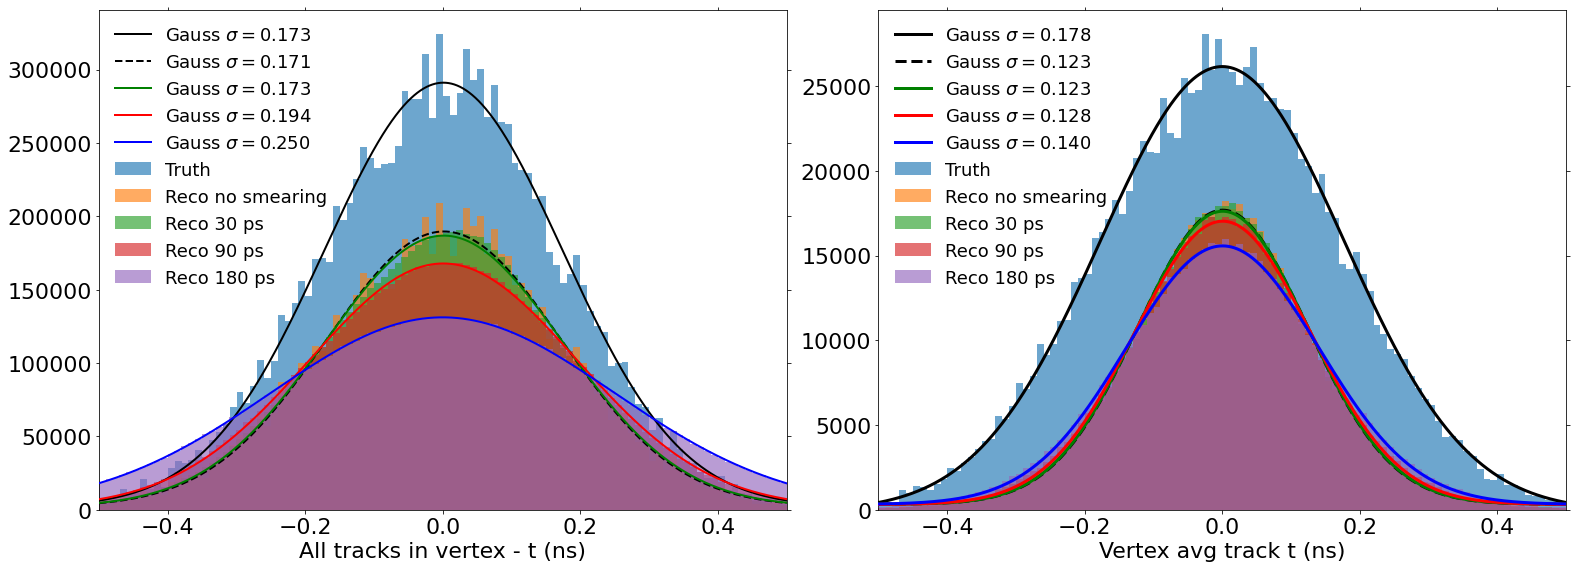

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(22, 8)

t_max = 0.5
labels = ['Truth', 'Reco no smearing', 'Reco 30 ps', 'Reco 90 ps', 'Reco 180 ps']
fmts = ['k-', 'k--', 'g', 'r', 'b']

for fmt, label, all_ts in zip(fmts, labels, (trv_all_ts_flat2, rev_all_ts_flat2, rev_all_ts30_flat2, rev_all_ts90_flat2, rev_all_ts180_flat2)):
    idxs = np.abs(all_ts) < t_max
    bin_heights, bin_borders, _ = ax1.hist(all_ts[idxs], bins=100, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax1.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=2, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)

for fmt, label, avg_ts in zip(fmts, labels, (trv_avg_ts_flat, rev_avg_ts_flat, rev_avg_ts30_flat, rev_avg_ts90_flat, rev_avg_ts180_flat)):
    idxs = np.abs(avg_ts) < t_max
    bin_heights, bin_borders, _ = ax2.hist(avg_ts[idxs], bins=100, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax2.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)

ax1.legend(frameon=False)
ax1.set_xlabel('All tracks in vertex - t (ns)')
ax1.set_xlim(-t_max, t_max)

ax2.legend(frameon=False, loc='upper left')
ax2.set_xlabel('Vertex avg track t (ns)')
ax2.set_xlim(-t_max, t_max)

fig.tight_layout()

In [23]:
## Focus on hard scatter and sum_pT2 cut of reco 
trv_all_ts_HS_flat = flatten_array(getFirstElems(trv_all_ts))
trv_avg_ts_HS_flat = getFirstElems(trv_avg_ts)

rev_pTcut_all_ts, rev_pTcut_avg_ts, _, _     = t_stats_tracks_in_vtxs_pTcut(track_t, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2,    15**2)
rev_pTcut_all_ts30, rev_pTcut_avg_ts30, _, _   = t_stats_tracks_in_vtxs_pTcut(track_t30, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2,  15**2)
rev_pTcut_all_ts90, rev_pTcut_avg_ts90, _, _   = t_stats_tracks_in_vtxs_pTcut(track_t90, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2,  15**2)
rev_pTcut_all_ts180, rev_pTcut_avg_ts180, _, _  = t_stats_tracks_in_vtxs_pTcut(track_t180, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)

rev_pTcut_all_ts_flat = flatten_array(rev_pTcut_all_ts)
rev_pTcut_all_ts_flat2 = flatten_array(rev_pTcut_all_ts_flat)

rev_pTcut_all_ts30_flat = flatten_array(rev_pTcut_all_ts30)
rev_pTcut_all_ts30_flat2 = flatten_array(rev_pTcut_all_ts30_flat)

rev_pTcut_all_ts90_flat = flatten_array(rev_pTcut_all_ts90)
rev_pTcut_all_ts90_flat2 = flatten_array(rev_pTcut_all_ts90_flat)

rev_pTcut_all_ts180_flat = flatten_array(rev_pTcut_all_ts180)
rev_pTcut_all_ts180_flat2 = flatten_array(rev_pTcut_all_ts180_flat)

rev_pTcut_avg_ts_flat = flatten_array(rev_pTcut_avg_ts)
rev_pTcut_avg_ts_flat2 = flatten_array(rev_pTcut_avg_ts_flat)

rev_pTcut_avg_ts30_flat = flatten_array(rev_pTcut_avg_ts30)
rev_pTcut_avg_ts30_flat2 = flatten_array(rev_pTcut_avg_ts30_flat)

rev_pTcut_avg_ts90_flat = flatten_array(rev_pTcut_avg_ts90)
rev_pTcut_avg_ts90_flat2 = flatten_array(rev_pTcut_avg_ts90_flat)

rev_pTcut_avg_ts180_flat = flatten_array(rev_pTcut_avg_ts180)
rev_pTcut_avg_ts180_flat2 = flatten_array(rev_pTcut_avg_ts180_flat)

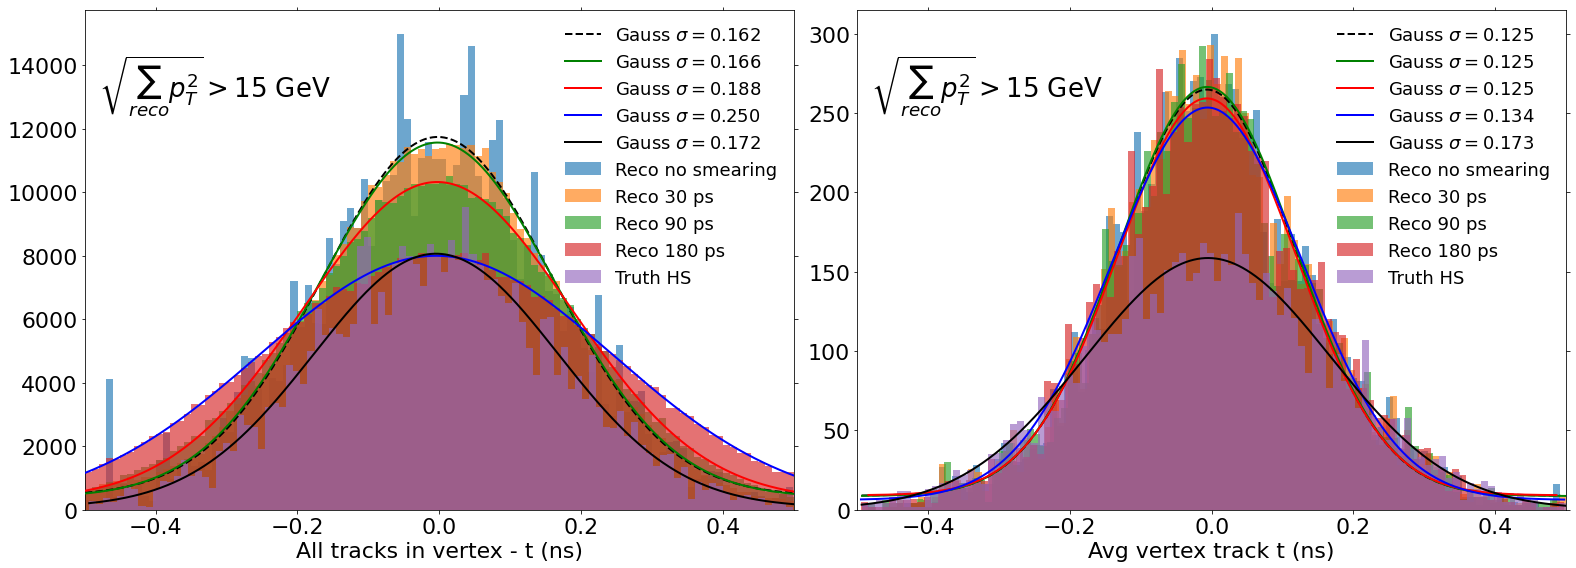

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(22, 8)

t_max = 0.5
labels = ['Reco no smearing', 'Reco 30 ps', 'Reco 90 ps', 'Reco 180 ps', 'Truth HS']
fmts = ['k--', 'g', 'r', 'b', 'k']

for fmt, label, all_ts in zip(fmts, labels, (rev_pTcut_all_ts_flat2, rev_pTcut_all_ts30_flat2, rev_pTcut_all_ts90_flat2, rev_pTcut_all_ts180_flat2, trv_all_ts_HS_flat)):
    idxs = np.abs(all_ts) < t_max
    bin_heights, bin_borders, _ = ax1.hist(all_ts[idxs], bins=100, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax1.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=2, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)

for fmt, label, avg_ts in zip(fmts, labels, (rev_pTcut_avg_ts_flat2, rev_pTcut_avg_ts30_flat2, rev_pTcut_avg_ts90_flat2, rev_pTcut_avg_ts180_flat2, trv_avg_ts_HS_flat)):
    idxs = np.abs(avg_ts) < t_max
    bin_heights, bin_borders, _ = ax2.hist(avg_ts[idxs], bins=100, alpha=0.65, density=False, label=label)
    
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussian, bin_centers, bin_heights, p0=[2500., 0., 0.1, 0])
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
    ax2.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt), fmt, lw=2, label='Gauss $\\sigma={:.3f}$'.format(abs(popt[2])), zorder=10)


ax1.text(-0.48, 13000, '$\\sqrt{\\sum_{reco} p^2_T} > 15$ GeV', fontsize=26)
ax1.legend(frameon=False)
ax1.set_xlabel('All tracks in vertex - t (ns)')
ax1.set_xlim(-t_max, t_max)

ax2.text(-0.48, 260, '$\\sqrt{\\sum_{reco} p^2_T} > 15$ GeV', fontsize=26)
ax2.legend(frameon=False)
ax2.set_xlabel('Avg vertex track t (ns)')
ax2.set_xlim(-t_max, t_max)

fig.tight_layout()

In [ ]:
## For a vertex check track ts vs track z 

In [53]:
## For each track in a vertex plot delta t = avt_t - track_t
delta_t_rms = []
n_tracks_rms = []
for v_avg_t, v_track_ts in zip(rev_avg_ts_flat, rev_all_ts_flat):
    clean_track_ts = v_track_ts[np.logical_and(v_track_ts != -1e3, v_track_ts != -1e6)]
    n_tracks_rms.append(len(clean_track_ts))
    delta_t_rms.append( np.mean((v_avg_t - clean_track_ts)**2)**0.5 )
delta_t_rms = np.array(delta_t_rms)
n_tracks_rms = np.array(n_tracks_rms)

delta_t_rms30 = []
n_tracks_rms30 = []
for v_avg_t, v_track_ts in zip(rev_avg_ts30_flat, rev_all_ts30_flat):
    clean_track_ts = v_track_ts[np.logical_and(v_track_ts != -1e3, v_track_ts != -1e6)]
    n_tracks_rms30.append(len(clean_track_ts))
    delta_t_rms30.append( np.mean((v_avg_t - clean_track_ts)**2)**0.5 )
delta_t_rms30 = np.array(delta_t_rms30)
n_tracks_rms30 = np.array(n_tracks_rms30)


delta_t_rms90 = []
n_tracks_rms90 = []
for v_avg_t, v_track_ts in zip(rev_avg_ts90_flat, rev_all_ts90_flat):
    clean_track_ts = v_track_ts[np.logical_and(v_track_ts != -1e3, v_track_ts != -1e6)]
    n_tracks_rms90.append(len(clean_track_ts))
    delta_t_rms90.append( np.mean((v_avg_t - clean_track_ts)**2)**0.5 )
delta_t_rms90 = np.array(delta_t_rms90)
n_tracks_rms90 = np.array(n_tracks_rms90)

delta_t_rms180 = []
n_tracks_rms180 = []
for v_avg_t, v_track_ts in zip(rev_avg_ts180_flat, rev_all_ts180_flat):
    clean_track_ts = v_track_ts[np.logical_and(v_track_ts != -1e3, v_track_ts != -1e6)]
    n_tracks_rms180.append(len(clean_track_ts))
    delta_t_rms180.append( np.mean((v_avg_t - clean_track_ts)**2)**0.5 )
delta_t_rms180 = np.array(delta_t_rms180)
n_tracks_rms180 = np.array(n_tracks_rms180)

/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ttlindkvist/.local/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


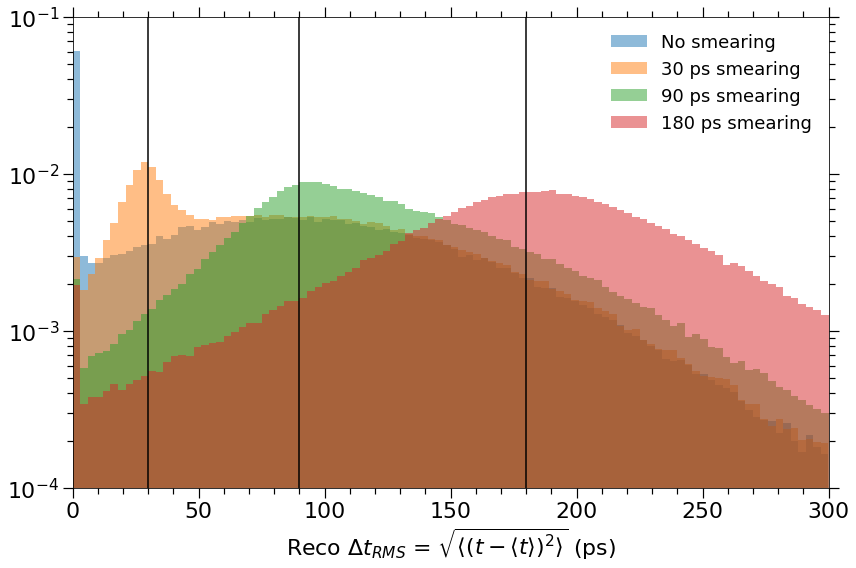

In [48]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_max = 300

idxs =      np.abs(1e3*delta_t_rms)   < t_max
idxs30 =    np.abs(1e3*delta_t_rms30) < t_max
idxs90 =    np.abs(1e3*delta_t_rms90) < t_max
idxs180 =   np.abs(1e3*delta_t_rms180)< t_max


_ = ax.hist(1e3*delta_t_rms[idxs], bins=100, label='No smearing',        density=True, alpha=0.5)
_ = ax.hist(1e3*delta_t_rms30[idxs30],  bins=100, label='30 ps smearing' , density=True, alpha=0.5)
_ = ax.hist(1e3*delta_t_rms90[idxs90],  bins=100, label='90 ps smearing' , density=True, alpha=0.5)
_ = ax.hist(1e3*delta_t_rms180[idxs180], bins=100, label='180 ps smearing', density=True, alpha=0.5)

ax.vlines(30, 1e-4, 1e-1, color='k')
ax.vlines(90, 1e-4, 1e-1, color='k')
ax.vlines(180, 1e-4, 1e-1, color='k')

ax.set_yscale('log')

ax.set_xlim(0, t_max)
ax.set_ylim(1e-4, 1e-1)
ax.set_xlabel('Reco $\Delta t_{RMS}$ = $\\sqrt{\\langle \\left(t - \\langle t\\rangle\\right)^2\\rangle}$ (ps)')

ax.tick_params(which='major', axis='both', length=10, width=1.2)
ax.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(50))

ax.legend(frameon=False)
fig.tight_layout()

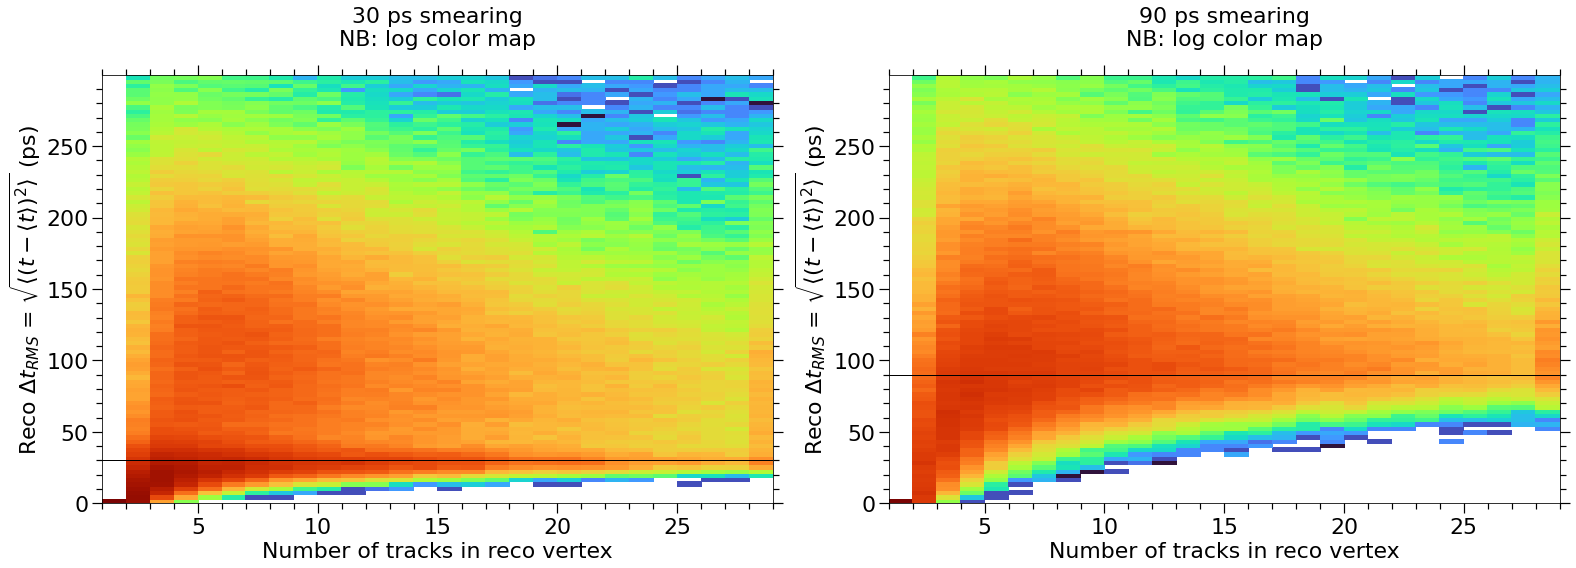

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(22, 8)

max_tracks = 30
t_max = 300

idx = np.logical_and(n_tracks_rms30 < max_tracks, 1e3*delta_t_rms30 < t_max)

n_tracks_bins = int(np.max(n_tracks_rms30[idx]) - np.min(n_tracks_rms30[idx]))
hist = ax1.hist2d(n_tracks_rms30[idx], 1e3*delta_t_rms30[idx], bins=(n_tracks_bins, 100), norm=mpl.colors.LogNorm(), cmap='turbo')

ax1.hlines(30, 0, max_tracks, color='k', lw=1)

ax1.tick_params(which='major', axis='both', length=10, width=1.2)
ax1.tick_params(which='minor', axis='both', length=6, width=1.2)
ax1.yaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(50))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))

ax1.set_xlabel('Number of tracks in reco vertex')
ax1.set_ylabel('Reco $\Delta t_{RMS}$ = $\\sqrt{\\langle \\left(t - \\langle t\\rangle\\right)^2\\rangle}$ (ps)')
ax1.set_title('30 ps smearing\nNB: log color map\n')

###########

idx = np.logical_and(n_tracks_rms90 < max_tracks, 1e3*delta_t_rms90 < t_max)

n_tracks_bins = int(np.max(n_tracks_rms90[idx]) - np.min(n_tracks_rms90[idx]))
hist = ax2.hist2d(n_tracks_rms90[idx], 1e3*delta_t_rms90[idx], bins=(n_tracks_bins, 100), norm=mpl.colors.LogNorm(), cmap='turbo')

ax2.hlines(90, 0, max_tracks, color='k', lw=1)

ax2.tick_params(which='major', axis='both', length=10, width=1.2)
ax2.tick_params(which='minor', axis='both', length=6, width=1.2)
ax2.yaxis.set_minor_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(50))
ax2.xaxis.set_minor_locator(MultipleLocator(1))
ax2.xaxis.set_major_locator(MultipleLocator(5))

ax2.set_xlabel('Number of tracks in reco vertex')
ax2.set_ylabel('Reco $\Delta t_{RMS}$ = $\\sqrt{\\langle \\left(t - \\langle t\\rangle\\right)^2\\rangle}$ (ps)')
ax2.set_title('90 ps smearing\nNB: log color map\n')

fig.tight_layout()

Text(0.5, 1.0, 'No smearing\nNB: log color map\n')

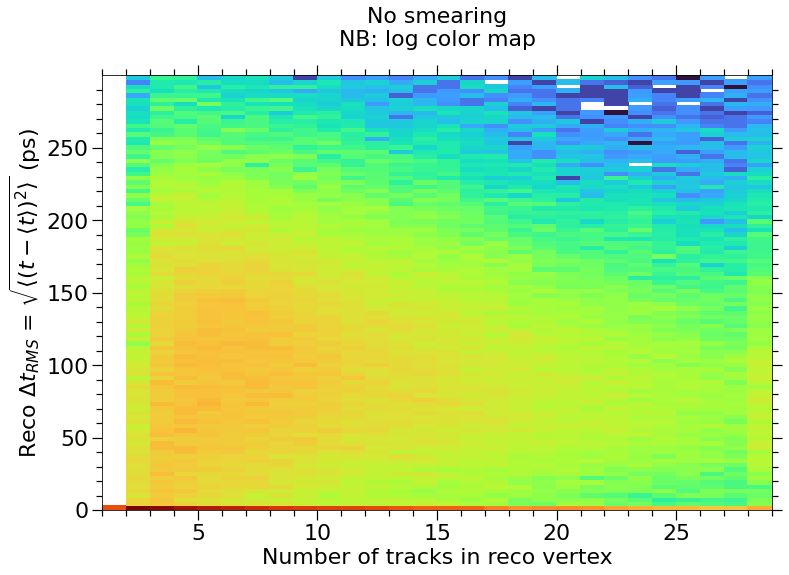

In [89]:
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

max_tracks = 30
t_max = 300

idx = np.logical_and(n_tracks_rms < max_tracks, 1e3*delta_t_rms < t_max)

n_tracks_bins = int(np.max(n_tracks_rms[idx]) - np.min(n_tracks_rms30[idx]))
hist = ax1.hist2d(n_tracks_rms[idx], 1e3*delta_t_rms[idx], bins=(n_tracks_bins, 100), norm=mpl.colors.LogNorm(), cmap='turbo')

ax1.tick_params(which='major', axis='both', length=10, width=1.2)
ax1.tick_params(which='minor', axis='both', length=6, width=1.2)
ax1.yaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(50))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.xaxis.set_major_locator(MultipleLocator(5))

ax1.set_xlabel('Number of tracks in reco vertex')
ax1.set_ylabel('Reco $\Delta t_{RMS}$ = $\\sqrt{\\langle \\left(t - \\langle t\\rangle\\right)^2\\rangle}$ (ps)')
ax1.set_title('No smearing\nNB: log color map\n')


findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica', 'Arial'] not found. Falling back to DejaVu Sans.


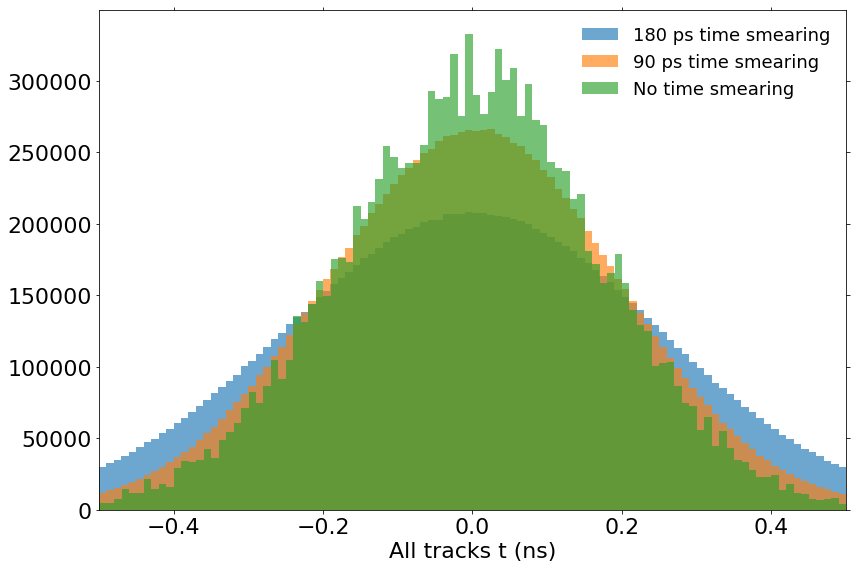

In [5]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_max = 0.5

idx   = np.abs(track_t_flat) < t_max
idx30 = np.abs(track_t30_flat) < t_max
idx90 = np.abs(track_t90_flat) < t_max
idx180 = np.abs(track_t180_flat) < t_max

_ = ax.hist(track_t180_flat[idx180], bins=100, alpha=0.65, density=False, label='180 ps time smearing')
_ = ax.hist(track_t90_flat [idx90],  bins=100, alpha=0.65, density=False, label='90 ps time smearing')
_ = ax.hist(track_t_flat   [idx],    bins=100, alpha=0.65, density=False, label='No time smearing')

ax.legend(frameon=False)
ax.set_xlabel('All tracks t (ns)')
ax.set_xlim(-t_max, t_max)
fig.tight_layout()

In [46]:
np.concatenate(trv_all_ts_flat)

array([-0.1931045 , -0.1931045 , -0.1931045 , ..., -0.24662176,
       -0.24662176, -0.24662176], dtype=float32)

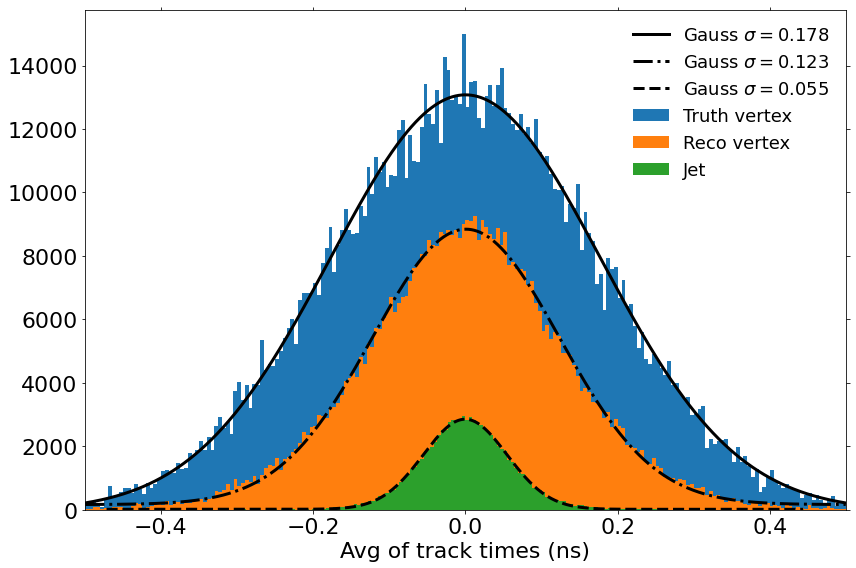

In [14]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_range = 0.5

bin_heights_trv, bin_borders_trv, _ = ax.hist(trv_avg_ts_flat[np.abs(trv_avg_ts_flat) < t_range], bins = 200, label='Truth vertex')
bin_heights_rev, bin_borders_rev, _ = ax.hist(rev_avg_ts_flat[np.abs(rev_avg_ts_flat) < t_range], bins = 200, label='Reco vertex')
bin_heights_jet, bin_borders_jet, _ = ax.hist(jet_avg_ts_flat[np.abs(jet_avg_ts_flat) < t_range], bins = 200, label='Jet')

bin_centers_trv = bin_borders_trv[:-1] + np.diff(bin_borders_trv) / 2
bin_centers_rev = bin_borders_rev[:-1] + np.diff(bin_borders_rev) / 2
bin_centers_jet = bin_borders_jet[:-1] + np.diff(bin_borders_jet) / 2
popt_trv, _ = curve_fit(gaussian, bin_centers_trv, bin_heights_trv, p0=[2500., 0., 0.1, 0])
popt_rev, _ = curve_fit(gaussian, bin_centers_rev, bin_heights_rev, p0=[2500., 0., 0.1, 0])
popt_jet, _ = curve_fit(gaussian, bin_centers_jet, bin_heights_jet, p0=[2500., 0., 0.1, 0])

#Plot fit
x_interval_for_fit = np.linspace(bin_borders_trv[0], bin_borders_trv[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_trv), 'k-', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_trv[2])), zorder=10)

x_interval_for_fit = np.linspace(bin_borders_rev[0], bin_borders_rev[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_rev), 'k-.', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_rev[2])), zorder=10)

x_interval_for_fit = np.linspace(bin_borders_jet[0], bin_borders_jet[-1], 10000)
ax.plot(x_interval_for_fit, gaussian(x_interval_for_fit, *popt_jet), 'k--', lw=3, label='Gauss $\\sigma={:.3f}$'.format(abs(popt_jet[2])), zorder=10)


ax.set_xlabel('Avg of track times (ns)')
ax.set_xlim(-t_range, t_range)
# plt.yscale('log')
ax.legend(frameon=False)

fig.tight_layout()

In [10]:
## TODO
## Reco vertex track times (with smearing) vs truth - only consider reco with sumpt2 > 15^2 GeV^2?

    
def t_stats_tracks_in_HS_vtxs(track_t, vertex_tracks_idx, vertex_zs):
    all_ts = []
    avg_ts = []
    rms_ts = []
    stat_zs = []
    
    for i, (event_vertex_track_idx, event_vertex_zs) in enumerate(zip(vertex_tracks_idx, vertex_zs)):
        event_all_ts = []
        event_avg_t = []
        event_rms_t = []
        event_stat_zs = []
        
        vertex_tracks = event_vertex_track_idx[0]
        z = event_vertex_zs[0]
        if len(vertex_tracks) > 0:
            ts = np.array(track_t[i][vertex_tracks])
            event_all_ts = ts
            
            avg_t = np.mean(ts)
            rms_t = np.sqrt(np.mean(ts**2))
            event_avg_t = avg_t
            event_rms_t = rms_t
            event_stat_zs = z
        avg_ts.append(event_avg_t)
        rms_ts.append(event_rms_t)
        stat_zs.append(event_stat_zs)
        all_ts.append(event_all_ts)
    
    return np.array(all_ts, dtype='object'), np.array(avg_ts, dtype='object'), np.array(rms_ts, dtype='object'), np.array(stat_zs, dtype='object')

In [11]:
rev_all_ts, rev_avg_ts, rev_rms_ts, rev_stat_z              = t_stats_tracks_in_vtxs_new(track_t, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts30, rev_avg_ts30, rev_rms_ts30, rev_stat_z30      = t_stats_tracks_in_vtxs_new(track_t30, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts90, rev_avg_ts90, rev_rms_ts90, rev_stat_z90      = t_stats_tracks_in_vtxs_new(track_t90, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)
rev_all_ts180, rev_avg_ts180, rev_rms_ts180, rev_stat_z180  = t_stats_tracks_in_vtxs_new(track_t180, reco_vertex_track_idxs, reco_vertex_z, reco_vertex_sumPt2, 15**2)

rev_all_ts_flat = flatten_array(rev_all_ts)
rev_all_ts30_flat = flatten_array(rev_all_ts30)
rev_all_ts90_flat = flatten_array(rev_all_ts90)
rev_all_ts180_flat = flatten_array(rev_all_ts180)

rev_avg_ts_flat = flatten_array(rev_avg_ts)
rev_avg_ts30_flat = flatten_array(rev_avg_ts30)
rev_avg_ts90_flat = flatten_array(rev_avg_ts90)
rev_avg_ts180_flat = flatten_array(rev_avg_ts180)

rev_rms_ts_flat = flatten_array(rev_rms_ts)
rev_rms_ts30_flat = flatten_array(rev_rms_ts30)
rev_rms_ts90_flat = flatten_array(rev_rms_ts90)
rev_rms_ts180_flat = flatten_array(rev_rms_ts180)

rev_stat_z_flat = flatten_array(rev_stat_z)
rev_stat_z30_flat = flatten_array(rev_stat_z30)
rev_stat_z90_flat = flatten_array(rev_stat_z90)
rev_stat_z180_flat = flatten_array(rev_stat_z180)

<ipython-input-10-7469ea8cde3a>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_ts.append (np.array(event_all_ts))


In [48]:
rev_all_ts_flat[1]

array([array([ 5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
              -1.0000000e+06,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               4.3889962e-02,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198199e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               2.2030523e-02,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5.5198097e-03,
               5.5198097e-03,  5.5198097e-03,  5.5198097e-03,  5

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6933 but corresponding boolean dimension is 13378

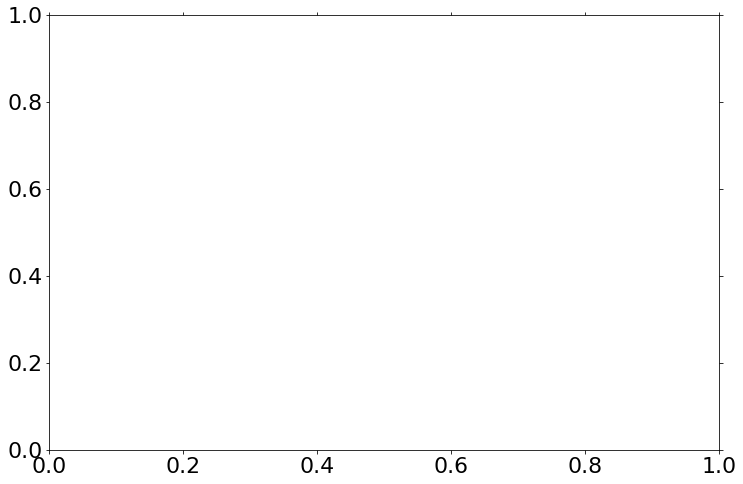

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 8)

t_max = 0.5

idx_rev    = np.abs(rev_avg_ts_flat) < t_max
idx_rev30  = np.abs(rev_avg_ts30_flat) < t_max
idx_rev90  = np.abs(rev_avg_ts90_flat) < t_max
idx_rev180 = np.abs(rev_avg_ts180_flat) < t_max


_ = ax.hist(rev_all_ts180_flat[idx_rev180], bins=100, alpha=0.65, density=False, label='Reco 180ps')
_ = ax.hist(rev_all_ts90_flat[idx_rev90], bins=100, alpha=0.65, density=False, label='Reco 90ps')
_ = ax.hist(rev_all_ts30_flat[idx_rev30], bins=100, alpha=0.65, density=False, label='Reco 30ps')
_ = ax.hist(rev_all_ts_flat[idx_rev], bins=100, alpha=0.65, density=False, label='Reco')

idx_trv = np.abs(trv_all_ts_flat) < t_max
_ = ax.hist(trv_avg_ts_flat[idx_trv],  bins=100, alpha=0.65, density=False, label='Truth')

ax.legend(frameon=False)
ax.set_xlabel('All tracks t (ns)')
ax.set_xlim(-t_max, t_max)
fig.tight_layout()

In [95]:
truth_vertex_track_idxs[100][50], reco_vertex_track_idxs[0][0]

(<STLVector [482] at 0x7f4c90448070>,
 <STLVector [75, 142, 404, 541, 590, ..., 1631, 1670, 1677, 1703] at 0x7f4c7305d760>)

In [ ]:
## Plot t or avg t of tracks belonging to verteces

(array([111.,  38.,  16.,  13.,  13.,   5.,   5.,   1.,   2.,   4.]),
 array([ 0. ,  4.5,  9. , 13.5, 18. , 22.5, 27. , 31.5, 36. , 40.5, 45. ]),
 <BarContainer object of 10 artists>)

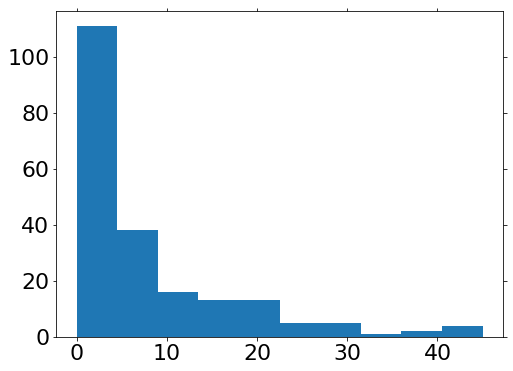

In [8]:
lens = []
for idxs in truth_vertex_track_idxs[0]:
    lens.append(len(idxs))

plt.hist(lens)

(array([14., 33., 22., 10.,  5.,  6.,  2.,  3.,  1.,  2.]),
 array([ 0. ,  3.8,  7.6, 11.4, 15.2, 19. , 22.8, 26.6, 30.4, 34.2, 38. ]),
 <BarContainer object of 10 artists>)

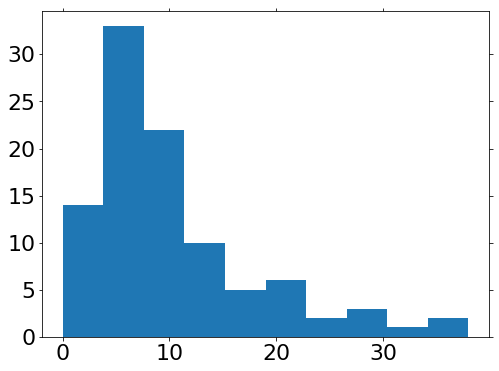

In [9]:
lens = []
for idxs in reco_vertex_track_idxs[0]:
    lens.append(len(idxs))

plt.hist(lens)